In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random
import string
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from scipy.stats.mstats import mquantiles
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Import & Explore DF on Exam Day

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/EthanRosehart/PM_Assignments/refs/heads/main/data_set_hackathon.csv')

# EDA

In [4]:
# Convert date columns to datetime format
df['order_date'] = pd.to_datetime(df['order_date'], format='%d.%m.%Y', errors='coerce')
df['requested_delivery_date'] = pd.to_datetime(df['requested_delivery_date'], format='%d.%m.%Y', errors='coerce')

# Calculate lead time (in days)
df['lead_time'] = (df['requested_delivery_date'] - df['order_date']).dt.days

# Convert 'items' column to numeric, coercing errors to NaN
df['items'] = pd.to_numeric(df['items'], errors='coerce')

# Drop rows with NaN in 'items' or 'lead_time'
valid_data = df.dropna(subset=['items', 'lead_time'])

# Compute summary statistics
summary_stats = {
    'Average Lead Time (days)': valid_data['lead_time'].mean(),
    'Median Lead Time (days)': valid_data['lead_time'].median(),
    'Average Order Value': valid_data['value'].mean(),
    'Total Order Value': valid_data['value'].sum(),
    'Average Items per Order': valid_data['items'].mean(),
    'Total Items': valid_data['items'].sum()
}

# Display summary statistics
for key, value in summary_stats.items():
    print(f"{key}: {value}")


Average Lead Time (days): 220.12729026036644
Median Lead Time (days): 217.0
Average Order Value: 1356.9929893924782
Total Order Value: 2814403.46
Average Items per Order: 8.288813886210221
Total Items: 17191.0


In [5]:
# Calculate the average quantity (items) per unique product code per order
avg_quantity_per_product = valid_data.groupby('Product Code')['items'].mean()

# Display the result
print("Average quantity per unique product code per order:")
print(avg_quantity_per_product.head(40))  


Average quantity per unique product code per order:
Product Code
L10705000     8.869565
L10705100     9.500000
L10705200     7.928571
L10705300    10.823529
L10705400    12.521739
L10705500    10.285714
L10705600     7.791667
L10705700     7.100000
L10850600     8.353846
L10850700     3.071429
L10850800     9.227273
L10850900     7.038462
L10852800     5.590909
L10852900    15.812500
L10853100     5.200000
L12134400     9.464286
L12134500     7.951220
L12134600    12.557692
L12134700     5.653846
L12135800     8.503876
L12135900     6.000000
L12136000     3.875000
L12136100     6.542553
L12916800     6.886364
L12916900     6.525000
L12917000     4.480000
L12917100     4.812500
L12917700     6.424242
L12917800    11.416667
L12917900     9.783019
L12918000    10.884615
L12918400     9.872727
L12918500     8.162791
L12918600     8.704918
L12918700     7.778846
L12918800     5.133333
L12918900     5.740741
L12919000     7.304348
L12919100     6.051282
L12919200    10.840000
Name: items, dt

Distribution Analysis

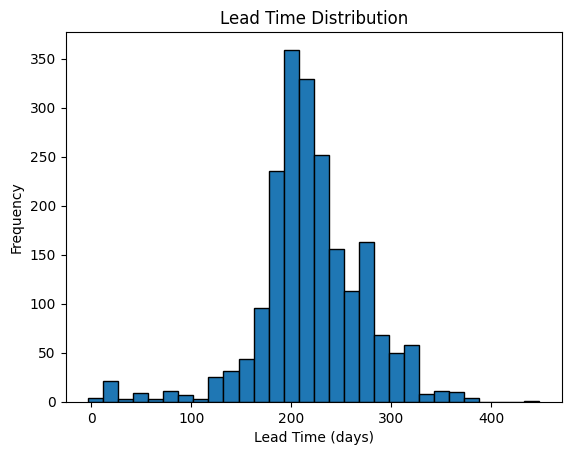

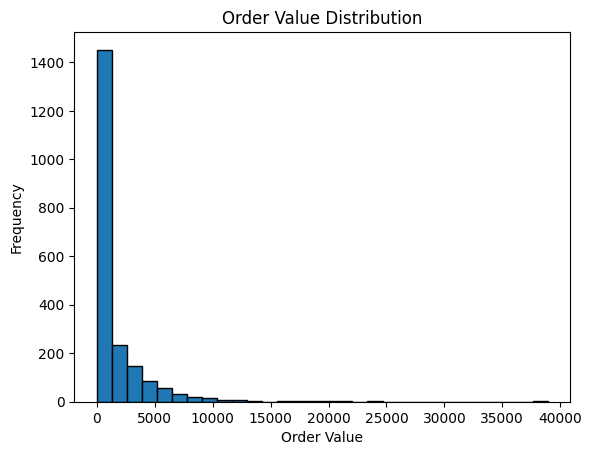

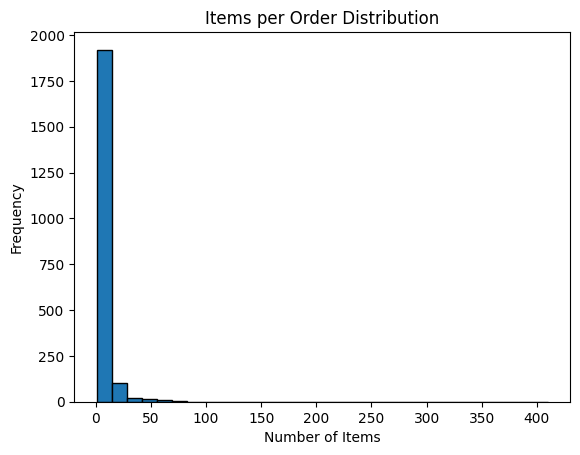

In [6]:
# Lead Time Distribution
plt.hist(valid_data['lead_time'], bins=30, edgecolor='black')
plt.title('Lead Time Distribution')
plt.xlabel('Lead Time (days)')
plt.ylabel('Frequency')
plt.show()

# Order Value Distribution
plt.hist(valid_data['value'], bins=30, edgecolor='black')
plt.title('Order Value Distribution')
plt.xlabel('Order Value')
plt.ylabel('Frequency')
plt.show()

# Items per Order Distribution
plt.hist(valid_data['items'], bins=30, edgecolor='black')
plt.title('Items per Order Distribution')
plt.xlabel('Number of Items')
plt.ylabel('Frequency')
plt.show()

Time-Based Analysis

C:\Users\Berry\AppData\Local\Temp\ipykernel_7860\601135788.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['order_month'] = valid_data['order_date'].dt.to_period('M')


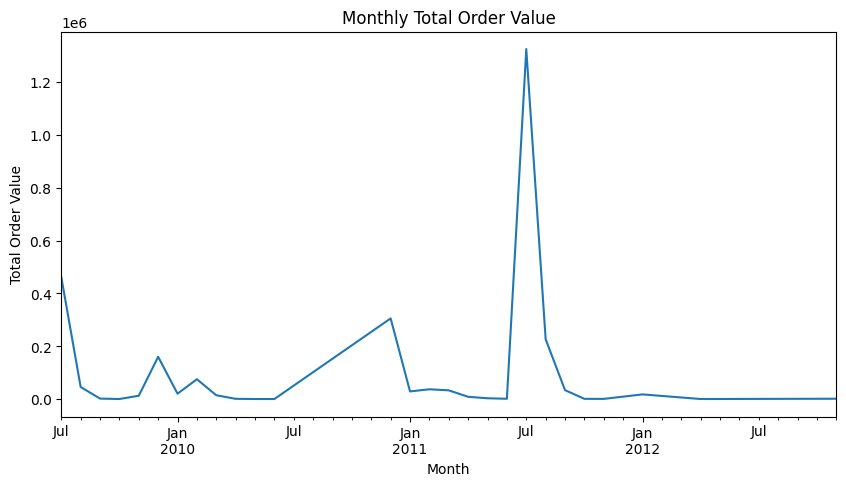

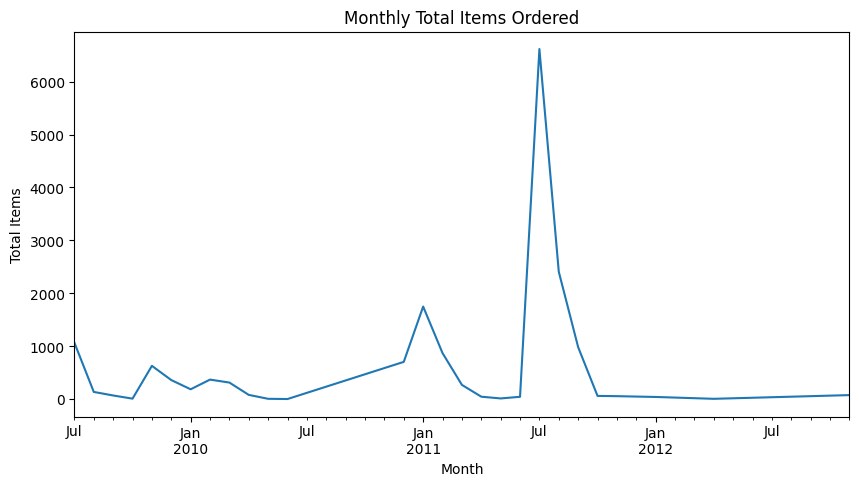

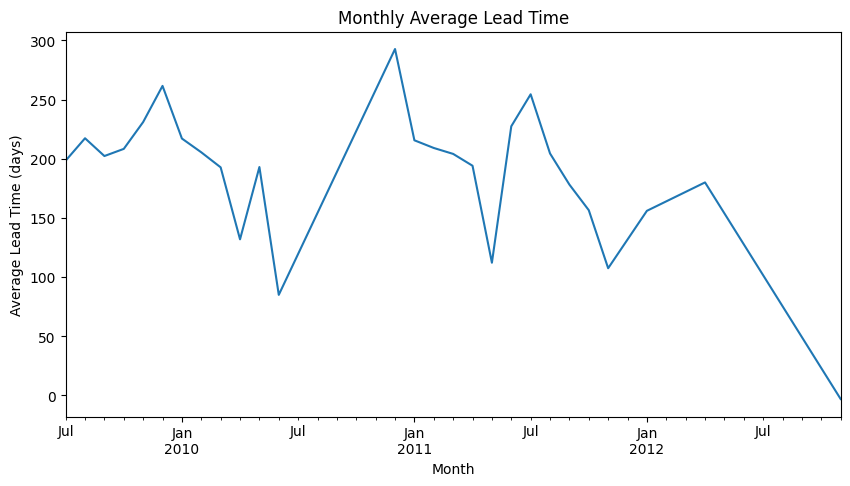

In [7]:
# Add a 'month' column for analysis
valid_data['order_month'] = valid_data['order_date'].dt.to_period('M')

# Group by month and calculate metrics
monthly_stats = valid_data.groupby('order_month').agg({
    'value': 'sum',
    'items': 'sum',
    'lead_time': 'mean'
})

# Plot trends
monthly_stats['value'].plot(title='Monthly Total Order Value', figsize=(10, 5))
plt.xlabel('Month')
plt.ylabel('Total Order Value')
plt.show()

monthly_stats['items'].plot(title='Monthly Total Items Ordered', figsize=(10, 5))
plt.xlabel('Month')
plt.ylabel('Total Items')
plt.show()

monthly_stats['lead_time'].plot(title='Monthly Average Lead Time', figsize=(10, 5))
plt.xlabel('Month')
plt.ylabel('Average Lead Time (days)')
plt.show()

Customer or Product Insights

In [8]:
# Top Customers by Revenue
top_customers = valid_data.groupby('Customer Country Code')['value'].sum().sort_values(ascending=False).head(10)
print("Top 10 Customers by Revenue:\n", top_customers)

# Top Products by Revenue
top_products = valid_data.groupby('Product Code')['value'].sum().sort_values(ascending=False).head(10)
print("Top 10 Products by Revenue:\n", top_products)


Top 10 Customers by Revenue:
 Customer Country Code
RU    2510835.67
CZ     130279.20
CH      52280.92
DE      17849.45
PL      15999.96
AT      11720.44
SE      10037.51
DK       9914.78
NO       9297.94
FR       8454.77
Name: value, dtype: float64
Top 10 Products by Revenue:
 Product Code
L12918400    294505.42
L12134400    238327.37
L12918700    192481.39
L12918500    191730.64
L12918600    170121.82
L12917800    153821.40
L12917900    124856.47
L10705400    119425.19
L10850600     99622.78
L12134500     99003.69
Name: value, dtype: float64


Outlier Detection

In [9]:
# Orders with unusually high values
high_value_orders = valid_data[valid_data['value'] > valid_data['value'].quantile(0.95)]
print("High Value Orders:\n", high_value_orders)

# Orders with long lead times
long_lead_time_orders = valid_data[valid_data['lead_time'] > valid_data['lead_time'].quantile(0.95)]
print("Orders with Long Lead Times:\n", long_lead_time_orders)


High Value Orders:
      order_date requested_delivery_date Customer Country Code Product Code  \
1    2009-07-15              2010-03-24                    RU    L10705000   
8    2009-07-21              2010-02-04                    RU    L10705000   
14   2009-08-07              2010-02-01                    RU    L10705000   
28   2009-07-16              2010-02-15                    RU    L10705100   
31   2009-07-24              2010-02-01                    RU    L10705100   
...         ...                     ...                   ...          ...   
1948 2011-07-19              2012-04-15                    RU    L12918700   
2257 2011-07-11              2012-04-30                    RU    L12919100   
2307 2011-07-08              2012-02-10                    CH    L12919200   
2311 2011-07-11              2012-04-30                    RU    L12919200   
2337 2011-07-19              2012-05-31                    RU    L12919200   

                      Description order_typ

Currency Analysis

In [10]:
# Revenue by Currency
currency_revenue = valid_data.groupby('Curr')['value'].sum().sort_values(ascending=False)
print("Revenue by Currency:\n", currency_revenue)

Revenue by Currency:
 Curr
RUB    2510835.67
CZK     129305.80
EUR      77528.39
CHF      49581.72
PLN      15999.96
DKK      11771.07
SEK      10037.51
NOK       9297.94
GBP         45.40
Name: value, dtype: float64


Route Analysis

In [11]:
# Average Lead Time by Route
route_lead_time = valid_data.groupby('Route')['lead_time'].mean().sort_values()
print("Average Lead Time by Route:\n", route_lead_time)

# Total Revenue by Route
route_revenue = valid_data.groupby('Route')['value'].sum().sort_values(ascending=False)
print("Total Revenue by Route:\n", route_revenue)


Average Lead Time by Route:
 Route
AD0001    131.642857
CE5001    162.000000
SE02FR    169.916667
AL0002    171.000000
BE0001    178.307692
SP0003    184.837209
FR0001    189.263889
FR02UA    192.631579
IT0000    193.431034
FR02EE    195.500000
NO02FR    198.894737
FR02KZ    199.000000
FI01FR    202.483871
FR01NL    203.285714
DE0005    203.617647
AT0003    203.810976
CH0001    203.921986
RO1001    206.000000
GB0005    212.000000
FR01CZ    213.707865
FR01DE    214.195489
FR01SI    218.418919
DK01FR    219.571429
FR01CH    220.450000
FI0003    222.217391
1         227.584906
FR02RO    227.750000
FR02BG    230.875000
FR02BY    233.083333
PT0001    236.000000
CZ0002    251.000000
SI0001    251.000000
RU0001    251.543165
Name: lead_time, dtype: float64
Total Revenue by Route:
 Route
RU0001    2510835.67
FR01CZ     121244.05
FR01CH      29601.92
1           27535.74
CH0001      19979.80
AT0003      11720.44
DK01FR      11312.78
FR0001      11153.97
FR01DE      10834.11
SE02FR      10037.51

# 1. How many Distinct Orders Are Received Each Month

In [12]:
# Convert the "order_date" column to datetime
df['order_date'] = pd.to_datetime(df['order_date'], format='%d.%m.%Y')

# Create separate columns for Year and Month
df['Year'] = df['order_date'].dt.year
df['Month'] = df['order_date'].dt.month

# Now group by Year and Month and count distinct Customer Order Codes
monthly_order_counts = (
    df.groupby(['Year', 'Month'])['Customer Order Code']
    .nunique()
    .reset_index(name='Distinct Order Count')
)

# Create a nicely formatted Year-Month column
monthly_order_counts['Year-Month'] = monthly_order_counts.apply(
    lambda row: f"{row['Year']}-{row['Month']:02d}", axis=1
)

print(monthly_order_counts)

    Year  Month  Distinct Order Count Year-Month
0   2009      7                    38    2009-07
1   2009      8                     9    2009-08
2   2009      9                    12    2009-09
3   2009     10                     4    2009-10
4   2009     11                     2    2009-11
5   2009     12                    21    2009-12
6   2010      1                    29    2010-01
7   2010      2                    36    2010-02
8   2010      3                    43    2010-03
9   2010      4                    11    2010-04
10  2010      5                     1    2010-05
11  2010      6                     1    2010-06
12  2010     12                    34    2010-12
13  2011      1                   124    2011-01
14  2011      2                    53    2011-02
15  2011      3                    29    2011-03
16  2011      4                     6    2011-04
17  2011      5                     4    2011-05
18  2011      6                     6    2011-06
19  2011      7     

In [13]:
# Dropping rows where 'value' is NULL
df = df.dropna(subset=['value'])

# Filtering out rows where Year is 2012
df = df[df['Year'] != 2012]

# Convert non-numeric values in the 'items' column to 0
df['items'] = pd.to_numeric(df['items'], errors='coerce').fillna(0).astype(int)

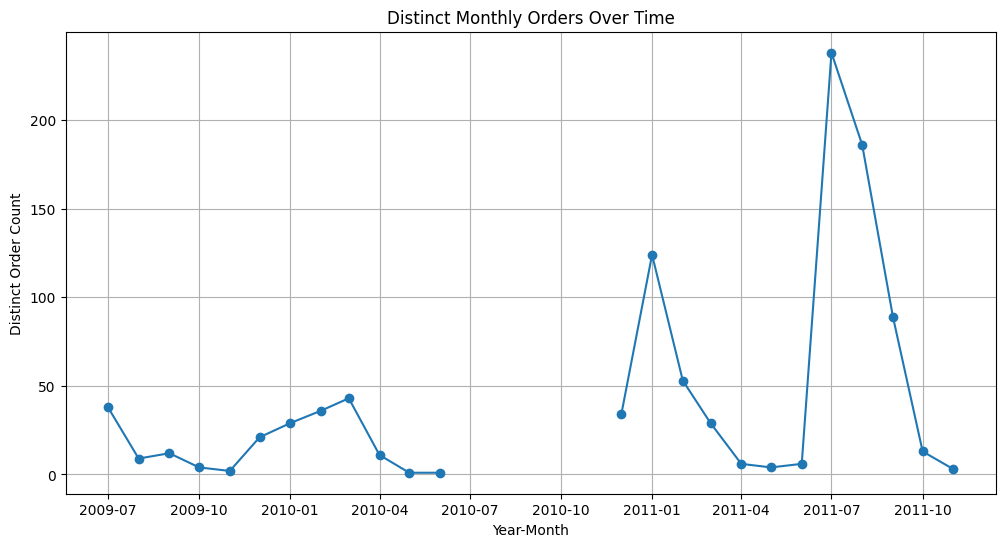

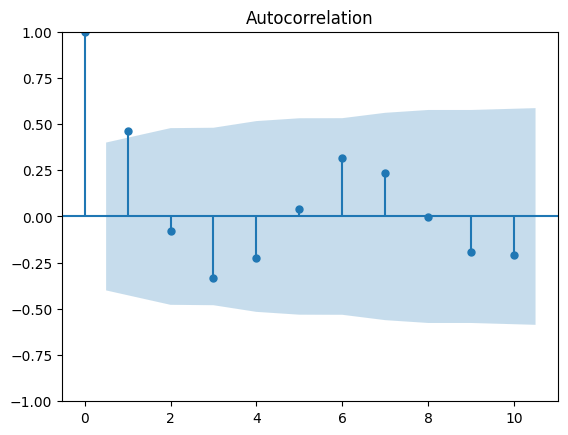

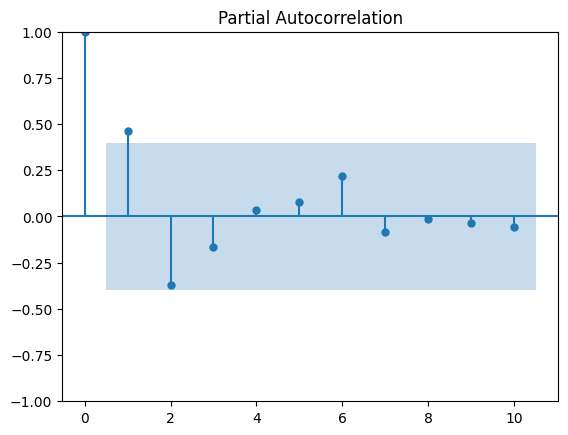

Best SARIMA order: (2, 1, 0) Seasonal order: (2, 1, 0, 6) with AIC: -15.164047787596722
                                     SARIMAX Results                                     
Dep. Variable:              Distinct Order Count   No. Observations:                   24
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 6)   Log Likelihood                  12.582
Date:                           Sun, 08 Dec 2024   AIC                            -15.164
Time:                                   19:46:55   BIC                            -19.671
Sample:                                        0   HQIC                           -24.224
                                            - 24                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4624      0.000  

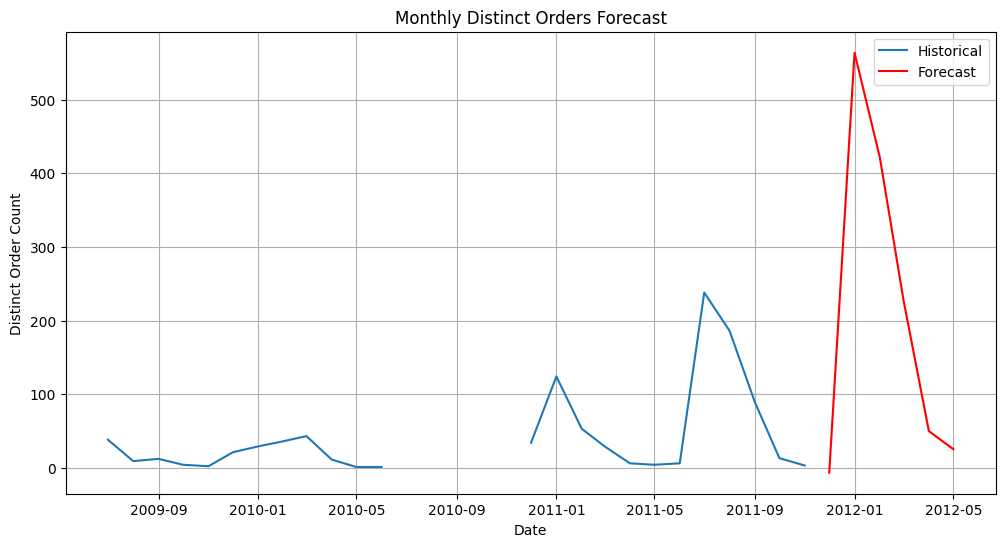

In [14]:
def prepare_monthly_time_series(df):
    # Ensure "order_date" is datetime
    if df['order_date'].dtype != 'datetime64[ns]':
        df['order_date'] = pd.to_datetime(df['order_date'], format='%d.%m.%Y', errors='coerce')
    
    # If "Year" and "Month" not in df, create them
    if 'Year' not in df.columns:
        df['Year'] = df['order_date'].dt.year
    if 'Month' not in df.columns:
        df['Month'] = df['order_date'].dt.month
    
    # Compute distinct order counts by Year-Month
    monthly_order_counts = (
        df.groupby(['Year', 'Month'])['Customer Order Code']
        .nunique()
        .reset_index(name='Distinct Order Count')
    )

    # Create Year-Month column if not present
    if 'Year-Month' not in monthly_order_counts.columns:
        monthly_order_counts['Year-Month'] = monthly_order_counts.apply(
            lambda row: f"{row['Year']}-{row['Month']:02d}", axis=1
        )
    
    # Convert "Year-Month" to datetime and set as index
    if monthly_order_counts.index.name != 'Year-Month':
        if not pd.api.types.is_datetime64_any_dtype(monthly_order_counts['Year-Month']):
            monthly_order_counts['Year-Month'] = pd.to_datetime(monthly_order_counts['Year-Month'], format='%Y-%m')
        monthly_order_counts.set_index('Year-Month', inplace=True)
    
    # Sort by index
    monthly_order_counts.sort_index(inplace=True)

    # Ensure monthly frequency
    time_series = monthly_order_counts['Distinct Order Count'].asfreq('MS')

    return time_series


def find_best_sarima_model(time_series,
                           p_values=range(0,3),
                           d_values=range(0,3),
                           q_values=range(0,3),
                           P_values=range(0,3),
                           D_values=range(0,2),
                           Q_values=range(0,3),
                           s_values=[6, 12]):  
    """
    This function does a brute-force grid search over given parameters for
    SARIMAX to find the best model based on AIC.
    
    Parameters:
    - time_series: pandas Series indexed by date
    - p_values, d_values, q_values: Ranges for the non-seasonal ARIMA parameters
    - P_values, D_values, Q_values, s_values: Ranges for seasonal ARIMA parameters and seasonal period
      For monthly data, s=12 might be common for yearly seasonality, 
      but you can try smaller or larger values.
    """
    best_aic = float("inf")
    best_order = None
    best_seasonal_order = None
    best_model = None

    warnings.filterwarnings("ignore")
    for p in p_values:
        for d in d_values:
            for q in q_values:
                for P in P_values:
                    for D in D_values:
                        for Q in Q_values:
                            for s in s_values:
                                # Avoid models that are trivially large compared to dataset size
                                # But here we try anyway
                                try:
                                    model = sm.tsa.statespace.SARIMAX(
                                        time_series.dropna(),
                                        order=(p, d, q),
                                        seasonal_order=(P, D, Q, s),
                                        enforce_stationarity=False,
                                        enforce_invertibility=False
                                    )
                                    results = model.fit(disp=False)
                                    if results.aic < best_aic:
                                        best_aic = results.aic
                                        best_order = (p, d, q)
                                        best_seasonal_order = (P, D, Q, s)
                                        best_model = results
                                except:
                                    continue
    return best_order, best_seasonal_order, best_aic, best_model


# Assuming df is your original DataFrame with "order_date" and "Customer Order Code"
time_series = prepare_monthly_time_series(df)

# Plot the time series
plt.figure(figsize=(12,6))
plt.plot(time_series.index, time_series.values, marker='o')
plt.title('Distinct Monthly Orders Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Distinct Order Count')
plt.grid(True)
plt.show()

# If time series is too short, reduce lags accordingly
lags = min(len(time_series.dropna())//2, 10)

sm.graphics.tsa.plot_acf(time_series.dropna(), lags=lags)
plt.show()

sm.graphics.tsa.plot_pacf(time_series.dropna(), lags=lags)
plt.show()

# Search for the best SARIMAX model
best_order, best_seasonal_order, best_aic, best_model = find_best_sarima_model(
    time_series,
    p_values=range(0,3),
    d_values=range(0,3),
    q_values=range(0,3),
    P_values=range(0,3),
    D_values=range(0,2),
    Q_values=range(0,3),
    s_values=[6, 12] # Testing a semi-annual and annual seasonality for a small dataset
)

print(f"Best SARIMA order: {best_order} Seasonal order: {best_seasonal_order} with AIC: {best_aic}")
print(best_model.summary())

# Forecast
steps_ahead = 6
forecast_res = best_model.get_forecast(steps=steps_ahead)
forecast_mean = forecast_res.predicted_mean
forecast_ci = forecast_res.conf_int()

print("Forecasted Distinct Orders:")
print(forecast_mean)
print("\nConfidence Intervals:")
print(forecast_ci)

# Plot the forecast
plt.figure(figsize=(12,6))
plt.plot(time_series.index, time_series.values, label='Historical')
future_index = pd.date_range(start=time_series.index[-1] + pd.offsets.MonthBegin(), periods=steps_ahead, freq='MS')
plt.plot(future_index, forecast_mean.values, label='Forecast', color='red')
plt.fill_between(future_index,
                 forecast_ci.iloc[:,0],
                 forecast_ci.iloc[:,1],
                 color='pink', alpha=0.3)
plt.title('Monthly Distinct Orders Forecast')
plt.xlabel('Date')
plt.ylabel('Distinct Order Count')
plt.legend()
plt.grid(True)
plt.show()


# 2. Which items are demanded (Classification Model)

In [15]:
# 1. Prepare the dataset
# Ensure order_date is a datetime
if df['order_date'].dtype != 'datetime64[ns]':
    df['order_date'] = pd.to_datetime(df['order_date'], format='%d.%m.%Y', errors='coerce')

# Extract month
df['Month'] = df['order_date'].dt.month

# Define a function to map month to season (example: Northern Hemisphere)
def month_to_season(m):
    if m in [12, 1, 2]:
        return 'Winter'
    elif m in [3, 4, 5]:
        return 'Spring'
    elif m in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

df['Season'] = df['Month'].apply(month_to_season)

# The target is "Product Code"
y = df['Product Code']

# Select features 
# Let's pick Season, Customer Country Code, and Route (NOT items)
categorical_features = ['Season', 'Customer Country Code', 'Route']

# Fill missing categorical with 'Unknown'
df[categorical_features] = df[categorical_features].fillna('Unknown')

# One-hot encode categorical variables
X = pd.get_dummies(df[categorical_features], drop_first=True)

# Remove rows with missing product codes if any
X = X[y.notna()]
y = y[y.notna()]

# 2. Split into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

class_names = list(y_test.unique())  # Replace y_test with y_train if needed

# 3. Fit a multinomial logistic regression model
from sklearn.linear_model import LogisticRegression
model_classification = LogisticRegression(random_state=0, max_iter=1000, multi_class='multinomial', solver='lbfgs')
model_classification.fit(X_train, y_train)

# 4. Make predictions
predictions = model_classification.predict(X_test)

# 5. Evaluate the model using F1-score (weighted average since multi-class)
from sklearn.metrics import f1_score, classification_report
f1 = f1_score(y_test, predictions, average='weighted')
print("F1-Score of the multinomial logistic regression model:", f1)

# Print the classification report
report = classification_report(y_test, predictions, target_names=class_names)
print("Classification Report:")
print(report)


F1-Score of the multinomial logistic regression model: 0.09717742997950822
Classification Report:
              precision    recall  f1-score   support

   L12918700       1.00      1.00      1.00         1
   L12918900       0.00      0.00      0.00         2
   L12918400       0.00      0.00      0.00         2
   L12919200       0.00      0.00      0.00         3
   L12135900       0.00      0.00      0.00         7
   L12919000       0.00      0.00      0.00         3
   L12918000       0.00      0.00      0.00         5
   L12917900       0.23      0.19      0.21        16
   L12917800       0.00      0.00      0.00         4
   L12918600       0.00      0.00      0.00        12
   L12134400       0.00      0.00      0.00         7
   L10850800       0.00      0.00      0.00         8
   L12135800       0.10      0.17      0.12         6
   L12917700       0.21      0.42      0.28        26
   L12134500       0.00      0.00      0.00        12
   L12916900       0.00      0.00    

# 3. Quantity Demanded

In [16]:
# Ensure 'order_date' is datetime if needed
if df['order_date'].dtype != 'datetime64[ns]':
    df['order_date'] = pd.to_datetime(df['order_date'], errors='coerce')

def month_to_season(m):
    if m in [12, 1, 2]:
        return 'Winter'
    elif m in [3, 4, 5]:
        return 'Spring'
    elif m in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

df['Season'] = df['Month'].apply(month_to_season)

# The target is 'Product Code'
y = df['Product Code']

# Features:
# We'll use 'Season', 'Customer Country Code', 'Route' (NOT items)
categorical_features = ['Season', 'Customer Country Code', 'Route']

# Fill missing categorical with 'Unknown'
df[categorical_features] = df[categorical_features].fillna('Unknown')

# One-hot encode categorical variables
X = pd.get_dummies(df[categorical_features], drop_first=True)

# Remove rows with missing product codes if any
X = X[y.notna()]
y = y[y.notna()]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit a multinomial logistic regression model
model_classification = LogisticRegression(random_state=0, max_iter=1000, multi_class='multinomial', solver='lbfgs')
model_classification.fit(X_train, y_train)

# Make predictions (Product Code)
predictions = model_classification.predict(X_test)

# Evaluate the model
f1 = f1_score(y_test, predictions, average='weighted')
print("F1-Score of the multinomial logistic regression model:", f1)
report = classification_report(y_test, predictions)
print("Classification Report:")
print(report)

# ----------------------------------------
# Now handle quantity demanded (items) uncertainty
# ----------------------------------------
# Compute empirical quantiles for each Product Code from the historical data (training + historical)
quantile_levels = [0.1, 0.5, 0.9]

product_quantiles = (
    df.groupby('Product Code')['items']
      .apply(lambda x: pd.Series(mquantiles(x, prob=quantile_levels), 
                                 index=[f"q_{int(q*100)}" for q in quantile_levels]))
).unstack()

# product_quantiles now has q_10, q_50, q_90 columns for each Product Code

# Get predicted product codes
predicted_product_codes = pd.Series(predictions, index=X_test.index, name='Predicted Product Code')

# Map predicted product codes to quantiles
product_quantiles = product_quantiles.rename_axis('Product Code')
predicted_quantiles = predicted_product_codes.to_frame().merge(
    product_quantiles,
    how='left',
    left_on='Predicted Product Code',
    right_on='Product Code'
)

# Add columns for interpreted predictions
predicted_quantiles['Predicted Quantity'] = predicted_quantiles['q_50']  # median as point estimate
predicted_quantiles['Lower Bound'] = predicted_quantiles['q_10']
predicted_quantiles['Upper Bound'] = predicted_quantiles['q_90']

print(predicted_quantiles[['Predicted Product Code', 'Predicted Quantity', 'Lower Bound', 'Upper Bound']].head())

F1-Score of the multinomial logistic regression model: 0.09717742997950822
Classification Report:
              precision    recall  f1-score   support

   L10705000       1.00      1.00      1.00         1
   L10705100       0.00      0.00      0.00         2
   L10705200       0.00      0.00      0.00         2
   L10705300       0.00      0.00      0.00         3
   L10705400       0.00      0.00      0.00         7
   L10705500       0.00      0.00      0.00         3
   L10705600       0.00      0.00      0.00         5
   L10850600       0.23      0.19      0.21        16
   L10850700       0.00      0.00      0.00         4
   L10850800       0.00      0.00      0.00        12
   L10850900       0.00      0.00      0.00         7
   L10852800       0.00      0.00      0.00         8
   L10852900       0.10      0.17      0.12         6
   L12134400       0.21      0.42      0.28        26
   L12134500       0.00      0.00      0.00        12
   L12134600       0.00      0.00    

# 4. Calculate Lead Time - Quantiles Method

In [17]:
#------------------------------------------------
# 1. Data Preparation
#------------------------------------------------

# Ensure 'order_date' is datetime
if df['order_date'].dtype != 'datetime64[ns]':
    df['order_date'] = pd.to_datetime(df['order_date'], format='%d.%m.%Y', errors='coerce')

# Ensure 'requested_delivery_date' is datetime
if df['requested_delivery_date'].dtype != 'datetime64[ns]':
    df['requested_delivery_date'] = pd.to_datetime(df['requested_delivery_date'], format='%d.%m.%Y', errors='coerce')

# Calculate lead time in days
df['lead_time'] = (df['requested_delivery_date'] - df['order_date']).dt.days

# Extract month to determine season
df['Month'] = df['order_date'].dt.month

def month_to_season(m):
    if m in [12, 1, 2]:
        return 'Winter'
    elif m in [3, 4, 5]:
        return 'Spring'
    elif m in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

df['Season'] = df['Month'].apply(month_to_season)

# The target is 'Product Code'
y = df['Product Code']

# Features: Season, Customer Country Code, Route (no items, no lead_time)
categorical_features = ['Season', 'Customer Country Code', 'Route']

# Fill missing categorical with 'Unknown'
df[categorical_features] = df[categorical_features].fillna('Unknown')

# One-hot encode categorical features
X = pd.get_dummies(df[categorical_features], drop_first=True)

# Remove rows with missing product codes
X = X[y.notna()]
y = y[y.notna()]

#------------------------------------------------
# 2. Classification Model
#------------------------------------------------

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_classification = LogisticRegression(random_state=0, max_iter=1000, multi_class='multinomial', solver='lbfgs')
model_classification.fit(X_train, y_train)

predictions = model_classification.predict(X_test)

f1 = f1_score(y_test, predictions, average='weighted')
print("F1-Score of the multinomial logistic regression model:", f1)
report = classification_report(y_test, predictions)
print("Classification Report:")
print(report)

#------------------------------------------------
# 3. Quantile Estimation for Items and Lead Time
#------------------------------------------------

# Define quantile levels
quantile_levels = [0.1, 0.5, 0.9]

# Compute quantiles for items by product code
product_items_quantiles = (
    df.groupby('Product Code')['items']
      .apply(lambda x: pd.Series(mquantiles(x, prob=quantile_levels), 
                                 index=[f"q_{int(q*100)}" for q in quantile_levels]))
).unstack()

product_items_quantiles = product_items_quantiles.rename_axis('Product Code')

# Compute quantiles for lead_time by product code
product_leadtime_quantiles = (
    df.groupby('Product Code')['lead_time']
      .apply(lambda x: pd.Series(mquantiles(x, prob=quantile_levels), 
                                 index=[f"q_{int(q*100)}" for q in quantile_levels]))
).unstack()

product_leadtime_quantiles = product_leadtime_quantiles.rename_axis('Product Code')

# Map predicted product codes to their quantiles
predicted_product_codes = pd.Series(predictions, index=X_test.index, name='Predicted Product Code')

# Merge for items
predicted_items_quantiles = predicted_product_codes.to_frame().merge(
    product_items_quantiles,
    how='left',
    left_on='Predicted Product Code',
    right_on='Product Code'
)

# Merge for lead time
predicted_leadtime_quantiles = predicted_product_codes.to_frame().merge(
    product_leadtime_quantiles,
    how='left',
    left_on='Predicted Product Code',
    right_on='Product Code'
)

# Add interpreted predictions:
# For items
predicted_items_quantiles['Predicted Quantity (median)'] = predicted_items_quantiles['q_50']
predicted_items_quantiles['Quantity Lower Bound'] = predicted_items_quantiles['q_10']
predicted_items_quantiles['Quantity Upper Bound'] = predicted_items_quantiles['q_90']

# For lead time
predicted_leadtime_quantiles['Predicted Lead Time (median)'] = predicted_leadtime_quantiles['q_50']
predicted_leadtime_quantiles['Lead Time Lower Bound'] = predicted_leadtime_quantiles['q_10']
predicted_leadtime_quantiles['Lead Time Upper Bound'] = predicted_leadtime_quantiles['q_90']

# Print a sample of the results
print("\nQuantile-based Predictions for Items:")
print(predicted_items_quantiles[['Predicted Product Code', 'Predicted Quantity (median)', 'Quantity Lower Bound', 'Quantity Upper Bound']].head())

print("\nQuantile-based Predictions for Lead Time:")
print(predicted_leadtime_quantiles[['Predicted Product Code', 'Predicted Lead Time (median)', 'Lead Time Lower Bound', 'Lead Time Upper Bound']].head())


F1-Score of the multinomial logistic regression model: 0.09717742997950822
Classification Report:
              precision    recall  f1-score   support

   L10705000       1.00      1.00      1.00         1
   L10705100       0.00      0.00      0.00         2
   L10705200       0.00      0.00      0.00         2
   L10705300       0.00      0.00      0.00         3
   L10705400       0.00      0.00      0.00         7
   L10705500       0.00      0.00      0.00         3
   L10705600       0.00      0.00      0.00         5
   L10850600       0.23      0.19      0.21        16
   L10850700       0.00      0.00      0.00         4
   L10850800       0.00      0.00      0.00        12
   L10850900       0.00      0.00      0.00         7
   L10852800       0.00      0.00      0.00         8
   L10852900       0.10      0.17      0.12         6
   L12134400       0.21      0.42      0.28        26
   L12134500       0.00      0.00      0.00        12
   L12134600       0.00      0.00    

# 5. Consolidate All Models and Predict Demand, Report MAPE (Compare to 5month forecast to 2 month forecast with Monte Carlo Sims)

In [21]:
#------------------------------------------------
# 1. Data Preparation (Same as before)
#------------------------------------------------

# Ensure order_date is datetime
if df['order_date'].dtype != 'datetime64[ns]':
    df['order_date'] = pd.to_datetime(df['order_date'], format='%d.%m.%Y', errors='coerce')

if df['requested_delivery_date'].dtype != 'datetime64[ns]':
    df['requested_delivery_date'] = pd.to_datetime(df['requested_delivery_date'], format='%d.%m.%Y', errors='coerce')

# Calculate lead time in days
df['lead_time'] = (df['requested_delivery_date'] - df['order_date']).dt.days

# Extract month to determine season
df['Month'] = df['order_date'].dt.month

def month_to_season(m):
    if m in [12, 1, 2]:
        return 'Winter'
    elif m in [3, 4, 5]:
        return 'Spring'
    elif m in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

df['Season'] = df['Month'].apply(month_to_season)

# The target is 'Product Code'
y = df['Product Code']

# Features for classification (no items, no lead_time)
categorical_features = ['Season', 'Customer Country Code', 'Route']
df[categorical_features] = df[categorical_features].fillna('Unknown')

X = pd.get_dummies(df[categorical_features], drop_first=True)
X = X[y.notna()]
y = y[y.notna()]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_classification = LogisticRegression(random_state=0, max_iter=1000, multi_class='multinomial', solver='lbfgs')
model_classification.fit(X_train, y_train)
predictions = model_classification.predict(X_test)

f1 = f1_score(y_test, predictions, average='weighted')
print("F1-Score of the multinomial logistic regression model:", f1)
report = classification_report(y_test, predictions)
print("Classification Report:")
print(report)

#------------------------------------------------
# 2. Prepare Historical Distributions for Monte Carlo
#------------------------------------------------

# We assume df contains all historical data
# Let's store historical items and lead_time per product code
historical_data = df.groupby('Product Code').apply(
    lambda g: pd.Series({
        'items': g['items'].dropna().values,
        'lead_time': g['lead_time'].dropna().values
    })
)

# historical_data now has for each Product Code a numpy array of items and lead_times
# Example:
# Product Code | items_array                    | lead_time_array
# ---------------------------------------------------------------
# L10705000    | array([5,6,7, ...])            | array([10, 12, 11, ...])
# L10705100    | array([2,2,3, ...])            | array([5, 4, 6, ...])

#------------------------------------------------
# 3. Monte Carlo Simulation
#------------------------------------------------

num_simulations = 1000  # how many times to simulate

# We'll simulate total demand (sum of all items) and classify demands by lead time threshold
lead_time_threshold = 7  # e.g., urgent if lead_time < 7 days, else advance

# Extract the test set predicted product codes
predicted_product_codes = pd.Series(predictions, index=X_test.index, name='Predicted Product Code')

# For the test set, we want to simulate each predicted instance multiple times
# We'll store results in a DataFrame
simulation_results = []

for sim in range(num_simulations):
    sim_items = []
    sim_advance_items = []
    sim_urgent_items = []
    
    for idx, product_code in predicted_product_codes.items():
        # Get historical arrays for this product code
        if product_code in historical_data.index:
            items_arr = historical_data.loc[product_code, 'items']
            lead_arr = historical_data.loc[product_code, 'lead_time']
            
            if len(items_arr) > 0 and len(lead_arr) > 0:
                # Randomly sample one item and one lead_time from the historical distribution
                sampled_items = np.random.choice(items_arr)
                sampled_lead = np.random.choice(lead_arr)
            else:
                # If no data, fallback to some default (0)
                sampled_items = 0
                sampled_lead = lead_time_threshold  # neutral
        else:
            # If product code not found, fallback
            sampled_items = 0
            sampled_lead = lead_time_threshold
        
        sim_items.append(sampled_items)
        
        # Classify demand
        if sampled_lead < lead_time_threshold:
            sim_urgent_items.append(sampled_items)
        else:
            sim_advance_items.append(sampled_items)
    
    # Sum across all predicted instances for this simulation run
    total_items = np.sum(sim_items)
    total_advance = np.sum(sim_advance_items)
    total_urgent = np.sum(sim_urgent_items)
    
    simulation_results.append({
        'simulation': sim,
        'total_items': total_items,
        'total_advance': total_advance,
        'total_urgent': total_urgent
    })

simulation_df = pd.DataFrame(simulation_results)

#------------------------------------------------
# 4. Analyze Simulation Results
#------------------------------------------------

# We now have a distribution of total items, advance items, and urgent items over many simulations.
print("\nSimulated Demand Distribution:")
print(simulation_df[['total_items', 'total_advance', 'total_urgent']].describe())

# Compare simulated advance demand with actual advance demand in the test set
# To do this, we need the actual test set product codes and their lead times and items.
test_data = df.loc[X_test.index, ['Product Code', 'items', 'lead_time']]
test_data = test_data.dropna(subset=['Product Code', 'items', 'lead_time'])

# Actual advance vs urgent in the test set
actual_advance = test_data.loc[test_data['lead_time'] >= lead_time_threshold, 'items'].sum()
actual_urgent = test_data.loc[test_data['lead_time'] < lead_time_threshold, 'items'].sum()
actual_total = test_data['items'].sum()

print("\nActual Test Set Demand:")
print(f"Total: {actual_total}, Advance: {actual_advance}, Urgent: {actual_urgent}")

# Compare to average simulated
avg_total = simulation_df['total_items'].mean()
avg_advance = simulation_df['total_advance'].mean()
avg_urgent = simulation_df['total_urgent'].mean()

print("\nAverage Simulated Demand:")
print(f"Total: {avg_total}, Advance: {avg_advance}, Urgent: {avg_urgent}")

# By comparing these values, you can see how well your simulation aligns with reality,
# and use that to calibrate your model or distribution assumptions.

F1-Score of the multinomial logistic regression model: 0.09717742997950822
Classification Report:
              precision    recall  f1-score   support

   L10705000       1.00      1.00      1.00         1
   L10705100       0.00      0.00      0.00         2
   L10705200       0.00      0.00      0.00         2
   L10705300       0.00      0.00      0.00         3
   L10705400       0.00      0.00      0.00         7
   L10705500       0.00      0.00      0.00         3
   L10705600       0.00      0.00      0.00         5
   L10850600       0.23      0.19      0.21        16
   L10850700       0.00      0.00      0.00         4
   L10850800       0.00      0.00      0.00        12
   L10850900       0.00      0.00      0.00         7
   L10852800       0.00      0.00      0.00         8
   L10852900       0.10      0.17      0.12         6
   L12134400       0.21      0.42      0.28        26
   L12134500       0.00      0.00      0.00        12
   L12134600       0.00      0.00    

<Figure size 1200x600 with 0 Axes>

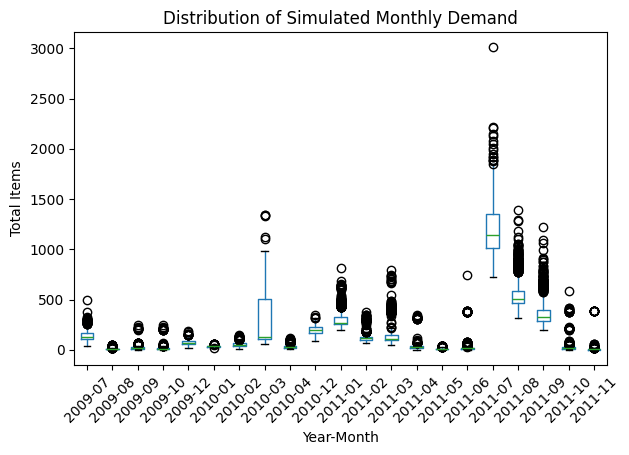

Simulations cover these Year-Month periods: ['2009-07' '2009-08' '2009-09' '2009-10' '2009-12' '2010-01' '2010-02'
 '2010-03' '2010-04' '2010-12' '2011-01' '2011-02' '2011-03' '2011-04'
 '2011-05' '2011-06' '2011-07' '2011-08' '2011-09' '2011-10' '2011-11']

Average Simulated Demand per Month:
YearMonth
2009-07     140.503
2009-08       6.262
2009-09      21.684
2009-10      17.549
2009-12      74.592
2010-01      33.471
2010-02      52.635
2010-03     254.949
2010-04      32.006
2010-12     199.567
2011-01     312.341
2011-02     123.545
2011-03     161.567
2011-04      33.624
2011-05       8.333
2011-06      25.617
2011-07    1199.883
2011-08     557.640
2011-09     367.680
2011-10      28.451
2011-11       9.957
Name: items, dtype: float64


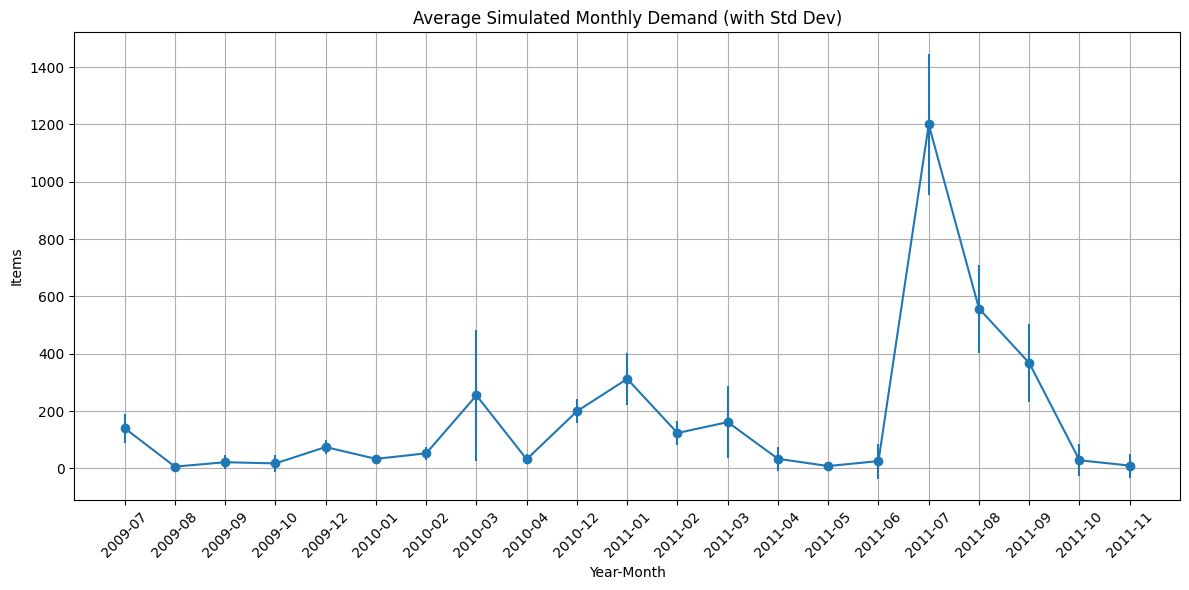

In [22]:
# First, ensure we have order_date for test instances
# If X_test and df share the same index or have a way to join:
test_indices = X_test.index
test_data = df.loc[test_indices, ['order_date', 'Product Code']]  # Actual data for test rows

# Add predicted product codes to test_data for alignment
test_data = test_data.join(predicted_product_codes, how='left')
test_data.rename(columns={'Predicted Product Code': 'predicted_code'}, inplace=True)

# Extract the month and year from order_date for grouping
test_data['YearMonth'] = test_data['order_date'].dt.to_period('M')  # Year-Month period

num_simulations = 1000
lead_time_threshold = 7

# Prepare a structure to hold simulation results by (simulation, YearMonth)
simulation_records = []

for sim in range(num_simulations):
    # For each simulation, we simulate the demand for each test record
    # Store results in a list, then convert to DataFrame
    sim_rows = []
    for idx, row in test_data.iterrows():
        product_code = row['predicted_code']
        yearmonth = row['YearMonth']
        
        if product_code in historical_data.index:
            items_arr = historical_data.loc[product_code, 'items']
            lead_arr = historical_data.loc[product_code, 'lead_time']
            
            if len(items_arr) > 0 and len(lead_arr) > 0:
                sampled_items = np.random.choice(items_arr)
                sampled_lead = np.random.choice(lead_arr)
            else:
                sampled_items = 0
                sampled_lead = lead_time_threshold
        else:
            sampled_items = 0
            sampled_lead = lead_time_threshold
        
        sim_rows.append({
            'YearMonth': yearmonth,
            'items': sampled_items,
            'lead_time': sampled_lead
        })

    sim_df = pd.DataFrame(sim_rows)
    # Aggregate by YearMonth to get monthly totals
    monthly_totals = sim_df.groupby('YearMonth')['items'].sum().reset_index()
    monthly_totals['simulation'] = sim
    simulation_records.append(monthly_totals)

all_simulations_df = pd.concat(simulation_records, ignore_index=True)

# Now we have a DataFrame with columns: YearMonth, items (monthly total), simulation
# We can visualize how demand is distributed across months.

# Convert YearMonth (period) back to a datetime for plotting or keep as string
all_simulations_df['YearMonth'] = all_simulations_df['YearMonth'].astype(str)

# Let's create a boxplot of the simulated monthly demands
plt.figure(figsize=(12,6))
all_simulations_df.boxplot(by='YearMonth', column='items', grid=False)
plt.title('Distribution of Simulated Monthly Demand')
plt.suptitle('')
plt.xlabel('Year-Month')
plt.ylabel('Total Items')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Alternatively, to see how long the test set covers:
months_covered = all_simulations_df['YearMonth'].unique()
print("Simulations cover these Year-Month periods:", months_covered)

# If you'd like to see the average simulated demand per month:
avg_monthly = all_simulations_df.groupby('YearMonth')['items'].mean()
print("\nAverage Simulated Demand per Month:")
print(avg_monthly)

# You can also plot a line chart of the average monthly demand with error bars (e.g. standard deviation)
monthly_stats = all_simulations_df.groupby('YearMonth')['items'].agg(['mean', 'std']).reset_index()
plt.figure(figsize=(12,6))
plt.errorbar(monthly_stats['YearMonth'], monthly_stats['mean'], yerr=monthly_stats['std'], fmt='-o')
plt.title('Average Simulated Monthly Demand (with Std Dev)')
plt.xlabel('Year-Month')
plt.ylabel('Items')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

5-Month Horizon Results:
Actual Total Demand: 2952
Simulated Average Total Demand: 634.821 ± 167.60478012670558

2-Month Horizon Results:
Actual Total Demand: 2621
Simulated Average Total Demand: 435.337 ± 103.37539312091104

Performance Comparison:
5-Month Forecast Error (absolute difference): 2317.179
2-Month Forecast Error (absolute difference): 2185.663


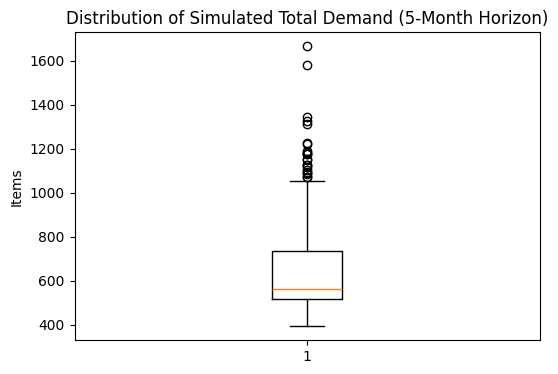

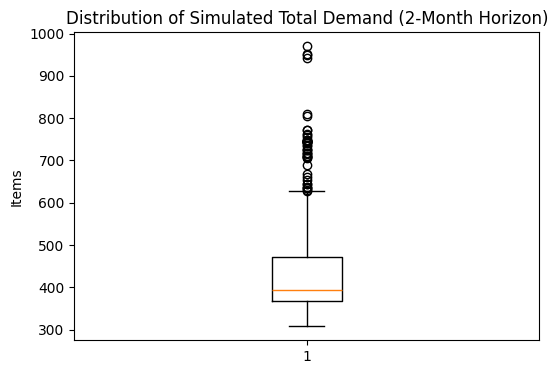

In [23]:
#---------------------------------------------------
# Assume you already have:
# - df: your main DataFrame with 'order_date', 'items', 'lead_time', 'Product Code'
# - historical_data: DataFrame with arrays of items and lead_time per Product Code
# - model_classification: your fitted classification model
# - X_test, y_test: your test features and target
# - predicted_product_codes: model predictions on X_test
# - num_simulations: number of Monte Carlo simulations
# - lead_time_threshold: threshold to distinguish advance vs urgent

# If not already done, ensure order_date is datetime
if df['order_date'].dtype != 'datetime64[ns]':
    df['order_date'] = pd.to_datetime(df['order_date'], errors='coerce')

# Join the test predictions back to the actual data
test_data = df.loc[X_test.index, ['order_date', 'Product Code']].copy()
test_data = test_data.join(predicted_product_codes, how='left')
test_data.rename(columns={'Predicted Product Code': 'predicted_code'}, inplace=True)

# Convert order_date to YearMonth period
test_data['YearMonth'] = test_data['order_date'].dt.to_period('M')

#---------------------------------------------------
# Define helper function to run simulation for a given time window
#---------------------------------------------------
def run_monte_carlo_for_period(test_data, historical_data, start_yearmonth, end_yearmonth, 
                               num_simulations=1000, lead_time_threshold=7):
    # Filter test_data by the chosen period
    mask = (test_data['YearMonth'] >= pd.Period(start_yearmonth)) & (test_data['YearMonth'] <= pd.Period(end_yearmonth))
    subset_data = test_data[mask]
    
    simulation_records = []
    for sim in range(num_simulations):
        sim_rows = []
        for idx, row in subset_data.iterrows():
            product_code = row['predicted_code']
            yearmonth = row['YearMonth']
            
            if product_code in historical_data.index:
                items_arr = historical_data.loc[product_code, 'items']
                lead_arr = historical_data.loc[product_code, 'lead_time']
                
                if len(items_arr) > 0 and len(lead_arr) > 0:
                    sampled_items = np.random.choice(items_arr)
                    sampled_lead = np.random.choice(lead_arr)
                else:
                    sampled_items = 0
                    sampled_lead = lead_time_threshold
            else:
                sampled_items = 0
                sampled_lead = lead_time_threshold
            
            sim_rows.append({
                'YearMonth': yearmonth,
                'items': sampled_items,
                'lead_time': sampled_lead
            })
        sim_df = pd.DataFrame(sim_rows)
        monthly_totals = sim_df.groupby('YearMonth')['items'].sum().reset_index()
        monthly_totals['simulation'] = sim
        simulation_records.append(monthly_totals)
    
    all_simulations_df = pd.concat(simulation_records, ignore_index=True)
    
    # Aggregate across all selected months to get total for the period
    # and also compute actual demand in this period
    # Actual data for this period:
    actual_mask = (df['order_date'].dt.to_period('M') >= pd.Period(start_yearmonth)) & \
                  (df['order_date'].dt.to_period('M') <= pd.Period(end_yearmonth))
    actual_subset = df[actual_mask]

    actual_total = actual_subset['items'].sum()
    actual_advance = actual_subset.loc[actual_subset['lead_time'] >= lead_time_threshold, 'items'].sum()
    actual_urgent = actual_subset.loc[actual_subset['lead_time'] < lead_time_threshold, 'items'].sum()
    
    # Compute simulated total over entire chosen period
    # Sum over all selected months for each simulation
    period_sums = all_simulations_df.groupby('simulation')['items'].sum()
    
    # Get average simulated totals
    avg_total = period_sums.mean()
    std_total = period_sums.std()
    
    # If needed, also compute simulated advance/urgent (you'd have to simulate lead_time classification by month as well)
    # For simplicity, let's focus on totals. If you already have code for advance/urgent classification, you can adapt it.

    return {
        'all_simulations_df': all_simulations_df,
        'actual_total': actual_total,
        'actual_advance': actual_advance,
        'actual_urgent': actual_urgent,
        'avg_total': avg_total,
        'std_total': std_total
    }

#---------------------------------------------------
# Run for a 5-month horizon
# Example: Let's pick 5 months in 2011 from January to May
five_month_result = run_monte_carlo_for_period(
    test_data=test_data,
    historical_data=historical_data,
    start_yearmonth='2011-01',
    end_yearmonth='2011-05',
    num_simulations=1000,
    lead_time_threshold=7
)

print("5-Month Horizon Results:")
print("Actual Total Demand:", five_month_result['actual_total'])
print("Simulated Average Total Demand:", five_month_result['avg_total'], "±", five_month_result['std_total'])

# Run for a 2-month horizon
# Example: Just Jan-Feb 2011
two_month_result = run_monte_carlo_for_period(
    test_data=test_data,
    historical_data=historical_data,
    start_yearmonth='2011-01',
    end_yearmonth='2011-02',
    num_simulations=1000,
    lead_time_threshold=7
)

print("\n2-Month Horizon Results:")
print("Actual Total Demand:", two_month_result['actual_total'])
print("Simulated Average Total Demand:", two_month_result['avg_total'], "±", two_month_result['std_total'])

#---------------------------------------------------
# Compare Performance
#---------------------------------------------------

# For simplicity, if you're using something like mean absolute error (MAE) or mean absolute percentage error (MAPE), you can do:
five_month_error = abs(five_month_result['avg_total'] - five_month_result['actual_total'])
two_month_error = abs(two_month_result['avg_total'] - two_month_result['actual_total'])

print("\nPerformance Comparison:")
print("5-Month Forecast Error (absolute difference):", five_month_error)
print("2-Month Forecast Error (absolute difference):", two_month_error)

# If the two-month error is smaller, it implies improved performance for a shorter forecast horizon.

# Optionally, visualize results similarly as before:
# For example, to boxplot the distribution of total demand simulations over the 5-month period:
five_month_simulations = five_month_result['all_simulations_df'].groupby('simulation')['items'].sum().reset_index()
plt.figure(figsize=(6,4))
plt.boxplot(five_month_simulations['items'])
plt.title("Distribution of Simulated Total Demand (5-Month Horizon)")
plt.ylabel("Items")
plt.show()

# And for the 2-month period:
two_month_simulations = two_month_result['all_simulations_df'].groupby('simulation')['items'].sum().reset_index()
plt.figure(figsize=(6,4))
plt.boxplot(two_month_simulations['items'])
plt.title("Distribution of Simulated Total Demand (2-Month Horizon)")
plt.ylabel("Items")
plt.show()

# Bringing it all together - Predict Production over 5 month horizon and 2 month horizon

F1-Score of the multinomial logistic regression model: 0.09717742997950822
Classification Report:
              precision    recall  f1-score   support

   L10705000       1.00      1.00      1.00         1
   L10705100       0.00      0.00      0.00         2
   L10705200       0.00      0.00      0.00         2
   L10705300       0.00      0.00      0.00         3
   L10705400       0.00      0.00      0.00         7
   L10705500       0.00      0.00      0.00         3
   L10705600       0.00      0.00      0.00         5
   L10850600       0.23      0.19      0.21        16
   L10850700       0.00      0.00      0.00         4
   L10850800       0.00      0.00      0.00        12
   L10850900       0.00      0.00      0.00         7
   L10852800       0.00      0.00      0.00         8
   L10852900       0.10      0.17      0.12         6
   L12134400       0.21      0.42      0.28        26
   L12134500       0.00      0.00      0.00        12
   L12134600       0.00      0.00    

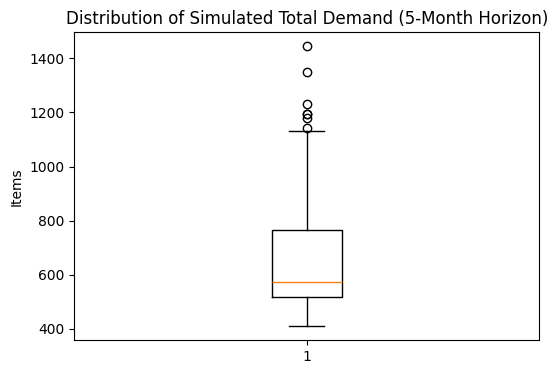

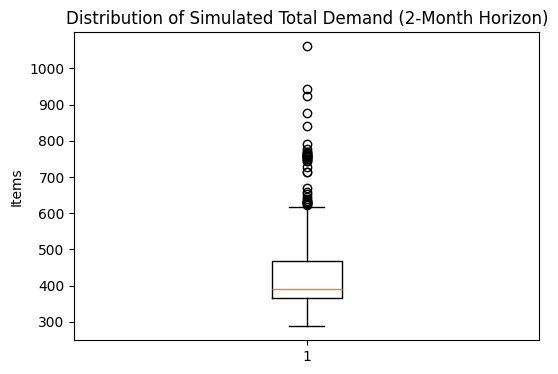

In [ ]:
#---------------------------------------------------
# 0. Preliminaries: Ensure order_date is datetime if not already
#---------------------------------------------------
if df['order_date'].dtype != 'datetime64[ns]':
    df['order_date'] = pd.to_datetime(df['order_date'], errors='coerce')

#---------------------------------------------------
# 1. Evaluate Model Performance (Optional)
#---------------------------------------------------
# If you haven't done so already:
predictions = predicted_product_codes
f1 = f1_score(y_test, predictions, average='weighted')
print("F1-Score of the multinomial logistic regression model:", f1)
report = classification_report(y_test, predictions)
print("Classification Report:")
print(report)

#---------------------------------------------------
# 2. Prepare Historical Distributions (historical_data)
#---------------------------------------------------
# Group by Product Code and store arrays of items and lead_time
historical_data = df.groupby('Product Code').apply(
    lambda g: pd.Series({
        'items': g['items'].dropna().values,
        'lead_time': g['lead_time'].dropna().values
    })
)

#---------------------------------------------------
# 3. Join test predictions with their order dates
#---------------------------------------------------
test_data = df.loc[X_test.index, ['order_date', 'Product Code']].copy()
test_data = test_data.join(predicted_product_codes, how='left')
test_data.rename(columns={'Predicted Product Code': 'predicted_code'}, inplace=True)

# Create a YearMonth period for easy time filtering
test_data['YearMonth'] = test_data['order_date'].dt.to_period('M')

#---------------------------------------------------
# 4. Function to run Monte Carlo simulations at product code level
#   for a given date range and horizon
#---------------------------------------------------
def run_monte_carlo_for_period(test_data, historical_data, start_yearmonth, end_yearmonth,
                               num_simulations=1000, lead_time_threshold=7):
    # Filter test_data to chosen horizon
    mask = (test_data['YearMonth'] >= pd.Period(start_yearmonth)) & (test_data['YearMonth'] <= pd.Period(end_yearmonth))
    subset_data = test_data[mask]
    
    simulation_records = []
    for sim in range(num_simulations):
        sim_rows = []
        for idx, row in subset_data.iterrows():
            product_code = row['predicted_code']
            yearmonth = row['YearMonth']
            
            if product_code in historical_data.index:
                items_arr = historical_data.loc[product_code, 'items']
                lead_arr = historical_data.loc[product_code, 'lead_time']
                
                if len(items_arr) > 0 and len(lead_arr) > 0:
                    sampled_items = np.random.choice(items_arr)
                    sampled_lead = np.random.choice(lead_arr)
                else:
                    sampled_items = 0
                    sampled_lead = lead_time_threshold
            else:
                sampled_items = 0
                sampled_lead = lead_time_threshold
            
            # Store per-line simulation
            sim_rows.append({
                'simulation': sim,
                'YearMonth': yearmonth,
                'Product Code': product_code,
                'items': sampled_items,
                'lead_time': sampled_lead
            })
        sim_df = pd.DataFrame(sim_rows)
        simulation_records.append(sim_df)
    
    all_scenarios_df = pd.concat(simulation_records, ignore_index=True)
    
    # Compute Actual totals in this period
    actual_mask = (df['order_date'].dt.to_period('M') >= pd.Period(start_yearmonth)) & \
                  (df['order_date'].dt.to_period('M') <= pd.Period(end_yearmonth))
    actual_subset = df[actual_mask]
    actual_total = actual_subset['items'].sum()
    
    # Compute simulated totals for this period (sum over all product codes and months)
    period_sums = all_scenarios_df.groupby('simulation')['items'].sum()
    avg_total = period_sums.mean()
    std_total = period_sums.std()
    
    return {
        'all_scenarios_df': all_scenarios_df,
        'actual_total': actual_total,
        'avg_total': avg_total,
        'std_total': std_total
    }

#---------------------------------------------------
# 5. Run Monte Carlo for 5-month horizon (Jan 2011 to May 2011)
#---------------------------------------------------
num_simulations = 1000
lead_time_threshold = 7
five_month_result = run_monte_carlo_for_period(
    test_data=test_data,
    historical_data=historical_data,
    start_yearmonth='2011-01',
    end_yearmonth='2011-05',
    num_simulations=num_simulations,
    lead_time_threshold=lead_time_threshold
)

print("\n5-Month Horizon Results:")
print("Actual Total Demand:", five_month_result['actual_total'])
print("Simulated Average Total Demand:", five_month_result['avg_total'], "±", five_month_result['std_total'])

#---------------------------------------------------
# 6. Run Monte Carlo for 2-month horizon (Jan 2011 to Feb 2011)
#---------------------------------------------------
two_month_result = run_monte_carlo_for_period(
    test_data=test_data,
    historical_data=historical_data,
    start_yearmonth='2011-01',
    end_yearmonth='2011-02',
    num_simulations=num_simulations,
    lead_time_threshold=lead_time_threshold
)

print("\n2-Month Horizon Results:")
print("Actual Total Demand:", two_month_result['actual_total'])
print("Simulated Average Total Demand:", two_month_result['avg_total'], "±", two_month_result['std_total'])

#---------------------------------------------------
# 7. Compare performance (simple absolute error)
#---------------------------------------------------
five_month_error = abs(five_month_result['avg_total'] - five_month_result['actual_total'])
two_month_error = abs(two_month_result['avg_total'] - two_month_result['actual_total'])

print("\nPerformance Comparison:")
print("5-Month Forecast Error (absolute difference):", five_month_error)
print("2-Month Forecast Error (absolute difference):", two_month_error)

#---------------------------------------------------
# 8. Derive Production Quantities Per Product Code
#    For each scenario, we have product-level items. We can use a quantile to choose production levels.
#---------------------------------------------------
def calculate_production_quantities(all_scenarios_df, quantile=0.9):
    # Aggregate by simulation and Product Code
    product_aggregates = all_scenarios_df.groupby(['simulation', 'Product Code'])['items'].sum().reset_index()
    # Compute quantiles per product
    product_stats = product_aggregates.groupby('Product Code')['items'].quantile([0.1, 0.5, quantile]).unstack()
    return product_stats[quantile]

# For 5-month horizon:
production_quantities_5m = calculate_production_quantities(five_month_result['all_scenarios_df'], quantile=0.9)
print("\nSuggested Production Quantities for 5-month horizon (90% quantile):")
print(production_quantities_5m)

# For 2-month horizon:
production_quantities_2m = calculate_production_quantities(two_month_result['all_scenarios_df'], quantile=0.9)
print("\nSuggested Production Quantities for 2-month horizon (90% quantile):")
print(production_quantities_2m)

#---------------------------------------------------
# 9. Visualizations
#---------------------------------------------------
# Boxplots of total demand simulations
five_month_sims = five_month_result['all_scenarios_df'].groupby('simulation')['items'].sum().reset_index()
plt.figure(figsize=(6,4))
plt.boxplot(five_month_sims['items'])
plt.title("Distribution of Simulated Total Demand (5-Month Horizon)")
plt.ylabel("Items")
plt.show()

two_month_sims = two_month_result['all_scenarios_df'].groupby('simulation')['items'].sum().reset_index()
plt.figure(figsize=(6,4))
plt.boxplot(two_month_sims['items'])
plt.title("Distribution of Simulated Total Demand (2-Month Horizon)")
plt.ylabel("Items")
plt.show()
